# Alliance Auth Merge Requests

This workbook provides analytics related to merge requests for the Alliance Auth project.

We are using live data fetched for the Alliance Auth project from GitLab. The source data is the list of merged merge request from 2018 until today.


In [1]:
"""imports & constants"""
import gitlab
import pandas as pd
import datetime as dt

GITLAB_PROJECT_ID = 6840712  # Alliance Auth project, related group ID is 2289351
START_YEAR = 2018


In [2]:
"""Fetch data from GitLab."""
# fetch raw data from gitlab
gl = gitlab.Gitlab("https://gitlab.com")
project = gl.projects.get(id=GITLAB_PROJECT_ID)
created_after = dt.datetime(START_YEAR - 1, 1, 1)
items = project.mergerequests.list(
    state="merged", created_after=created_after.isoformat(), all=True
)
data = [
    {
        "iid": item.iid,
        "title": item.title,
        "author": item.author["name"],
        "created_at": item.created_at,
        "merged_at": item.merged_at,
        "merged_by": item.merged_by["name"] if item.merged_by else None,
    }
    for item in items
]


In [3]:
"""Create dataframe from raw data."""
df = pd.DataFrame(data)
# prepare raw data
df["created_at"] = pd.to_datetime(df["created_at"])
df["merged_at"] = pd.to_datetime(df["merged_at"])
df = df.drop(df[df.merged_at.isnull()].index)  # remove MRs that have not been merged
df["merged_at_year"] = df["merged_at"].dt.year
df["review_duration"] = df["merged_at"] - df["created_at"]
# filter out MRs that have been merged before start year
lower_limit = pd.Timestamp(dt.datetime(START_YEAR, 1, 1)).tz_localize("UTC")
df = df[(df.merged_at >= lower_limit)]


## Who were the top contributors over the years?


In [4]:
def generate_totals_pie_chart(group_by: str):
    """Calculate Total MRs pie chart"""
    df2 = df[(df.review_duration > dt.timedelta(hours=3))]
    start_year = df2.merged_at.min().year
    end_year = df2.merged_at.max().year
    total_by_autor = df2.groupby(group_by)[group_by].count()
    threshold = 5
    totals_mains = total_by_autor[total_by_autor >= threshold]
    totals_others = total_by_autor[total_by_autor < threshold]
    totals_all = pd.concat([totals_mains, pd.Series({"other": totals_others.sum()})])
    plot = totals_all.plot(
        kind="pie",
        autopct=lambda p: "{:.0f}".format((p / 100) * totals_all.sum()),
        figsize=(8.3, 11.7),
        title=f"Contributions by {group_by} ({start_year} - {end_year})",
        ylabel="",
    )
    fig = plot.get_figure()
    fig.patch.set_facecolor("white")
    return fig


/tmp/ipykernel_639467/3025750930.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_totals_pie_chart("author").show()


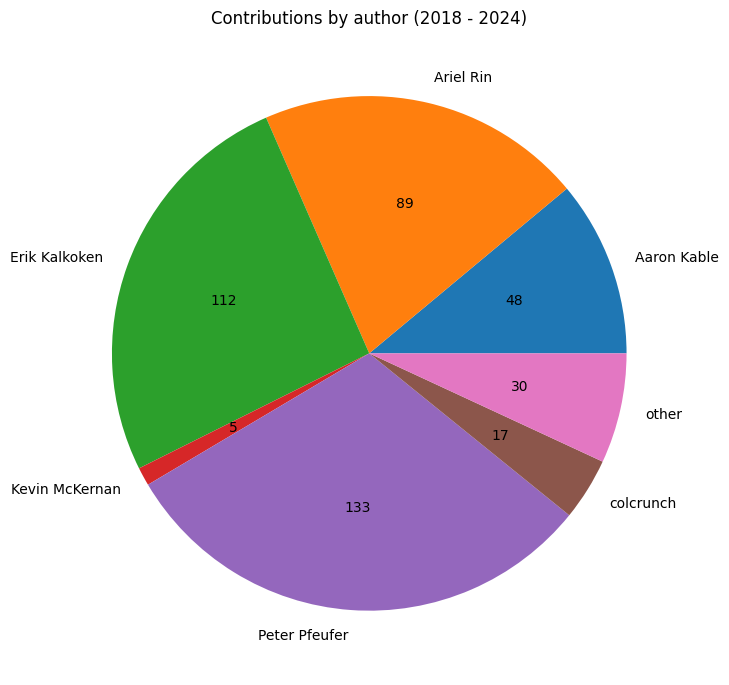

In [5]:
generate_totals_pie_chart("author").show()


/tmp/ipykernel_639467/2421439505.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_totals_pie_chart("merged_by").show()


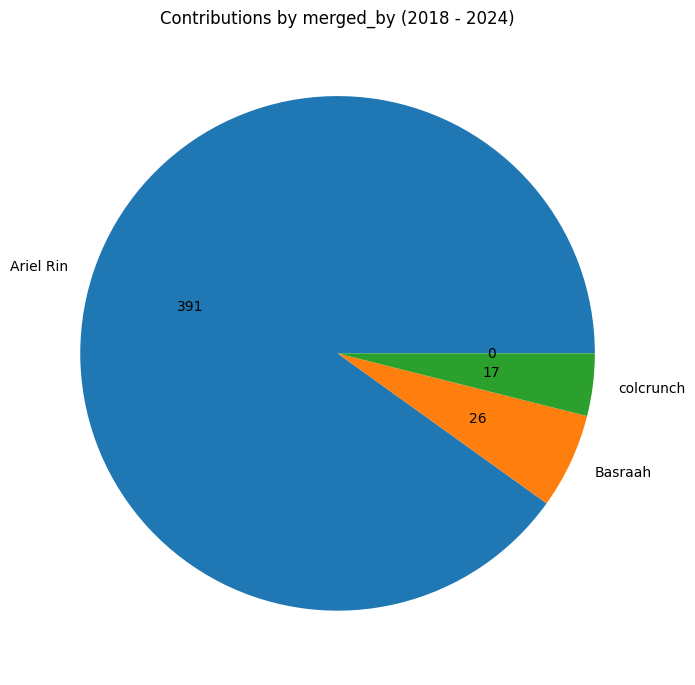

In [6]:
generate_totals_pie_chart("merged_by").show()

In [7]:
def generate_multi_year_chart(
    my_df: pd.DataFrame, group_by: str, top_count: int, label: str
):
    """Generate multi-year chart."""
    series = df.groupby([df.merged_at, df[group_by]]).size()
    my_df = series.unstack()
    # consolidate smaller columns into other
    column_totals = sorted(my_df.sum().items(), key=lambda col: col[1], reverse=True)
    top_columns = [col[0] for col in column_totals[:top_count]]
    columns_to_drop = [col[0] for col in column_totals if col[0] not in top_columns]
    if columns_to_drop:
        my_df["other"] = my_df[columns_to_drop].sum(axis=1)
        my_df = my_df.drop(columns=columns_to_drop)
        top_columns += ["other"]
    my_df = my_df.resample("3M").sum()
    graph_df = my_df[top_columns]
    start_year = df.merged_at.min().year
    end_year = df.merged_at.max().year
    ax = graph_df.plot.area(
        title=(f"Merged MRs by TOP {top_count} {label} ({start_year} - {end_year})"),
        figsize=(11.7, 8.3),
    )
    fig = ax.get_figure()
    fig.patch.set_facecolor("white")
    return fig


/tmp/ipykernel_639467/2071051075.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  my_df = my_df.resample("3M").sum()
/tmp/ipykernel_639467/2060816837.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_multi_year_chart(df, "author", 5, "authors").show()


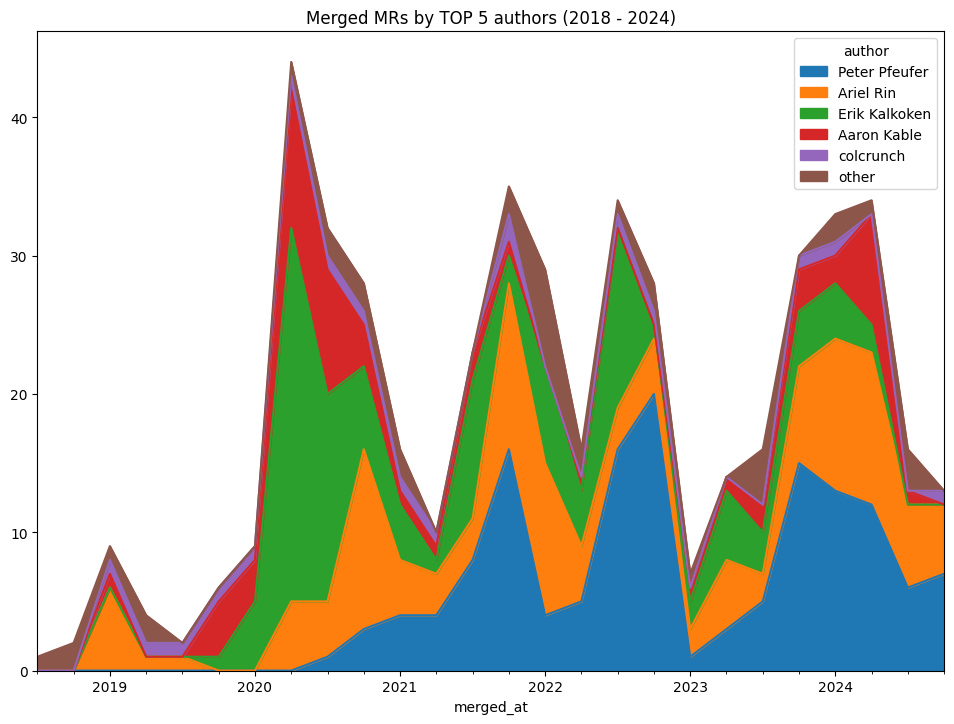

In [8]:
generate_multi_year_chart(df, "author", 5, "authors").show()


In [9]:
generate_multi_year_chart(df, "merged_by", 5, "maintainers").show()


/tmp/ipykernel_639467/2071051075.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  my_df = my_df.resample("3M").sum()
/tmp/ipykernel_639467/3992278815.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_multi_year_chart(df, "merged_by", 5, "maintainers").show()


## Who were the top contributors each year?


In [10]:
def generate_year_pie_chart(df: pd.DataFrame, group_by: str, year: int):
    """Generate year pie chart for all contributors."""
    lower_limit = pd.Timestamp(dt.datetime(year, 1, 1)).tz_localize("UTC")
    upper_limit = pd.Timestamp(dt.datetime(year, 12, 31, 23, 59, 59)).tz_localize("UTC")
    df_year = df[(df.merged_at >= lower_limit) & (df.merged_at < upper_limit)]
    series = df_year.groupby(group_by).size()
    series.name = "MR count"
    plot = series.plot(
        kind="pie",
        autopct=lambda p: "{:.0f}".format((p / 100) * series.sum()),
        title=f"Merged MRs by {group_by} ({year})",
        figsize=(8.3, 11.7),
    )
    fig = plot.get_figure()
    fig.patch.set_facecolor("white")
    return fig


/tmp/ipykernel_639467/999238397.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_year_pie_chart(df, "author", 2018).show()


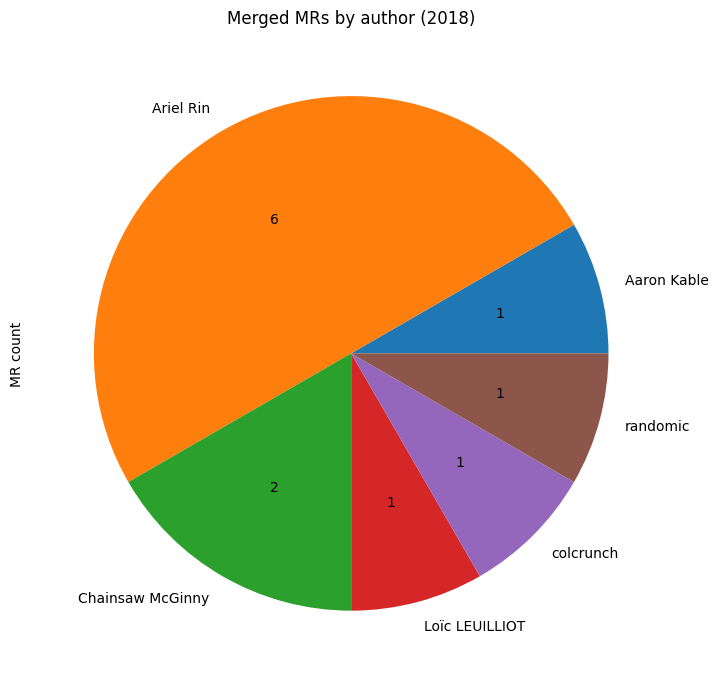

In [11]:
generate_year_pie_chart(df, "author", 2018).show()


/tmp/ipykernel_639467/3997160931.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_year_pie_chart(df, "author", 2019).show()


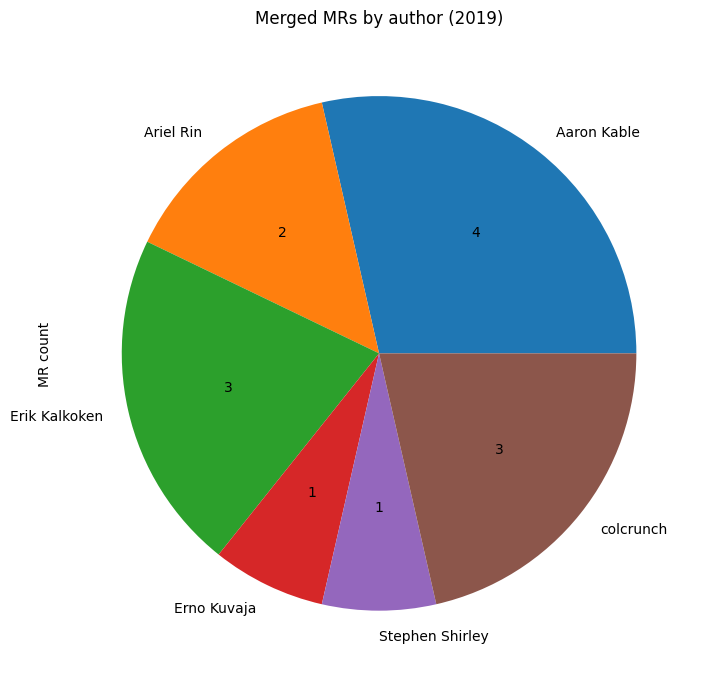

In [12]:
generate_year_pie_chart(df, "author", 2019).show()


/tmp/ipykernel_639467/3985864944.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_year_pie_chart(df, "author", 2020).show()


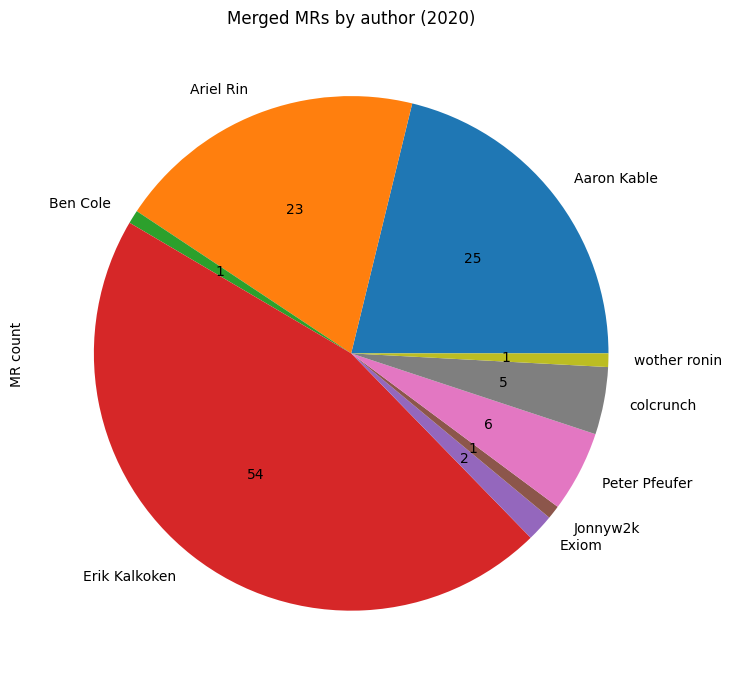

In [13]:
generate_year_pie_chart(df, "author", 2020).show()


/tmp/ipykernel_639467/2055323804.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  generate_year_pie_chart(df, "author", 2021).show()


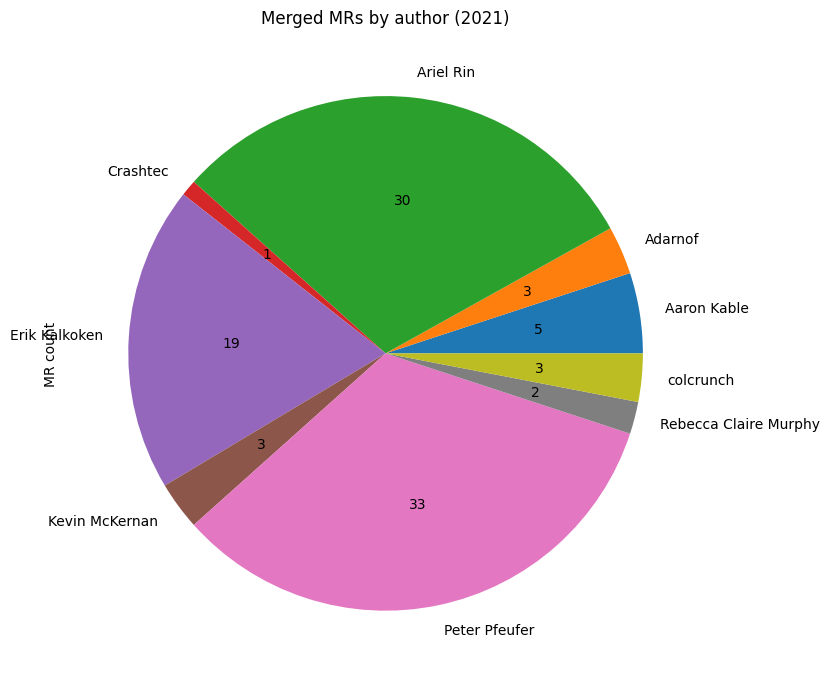

In [14]:
generate_year_pie_chart(df, "author", 2021).show()


## What is the average review time for an MR?


/tmp/ipykernel_639467/2640835591.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


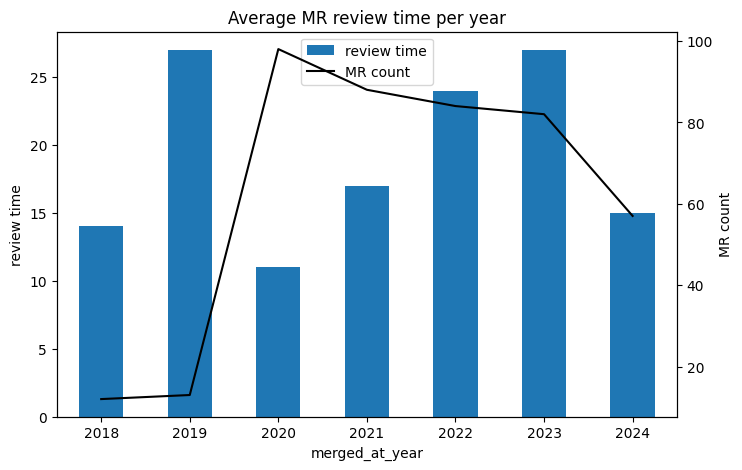

In [15]:
"""Generate chart for average MR review time per year."""
df_filtered = df[(df.review_duration > dt.timedelta(hours=3))]
review_time_per_year = (
    df_filtered.groupby("merged_at_year")["review_duration"].mean().dt.days
).rename("review time")
mrs_per_year = df_filtered.groupby("merged_at_year")["iid"].count().rename("MR count")

df2 = pd.merge(review_time_per_year, mrs_per_year, left_index=True, right_index=True)
ax = df2.plot.bar(y="review time", ylabel="review time", figsize=(8, 5))
df2.plot(
    y="MR count", c="k", ax=ax, use_index=False, secondary_y=True, mark_right=False
)
ax.right_ax.set_ylabel("MR count")
ax.set_title("Average MR review time per year")
fig = ax.get_figure()
fig.patch.set_facecolor("white")
fig.show()
